<a href="https://colab.research.google.com/github/neihtfool/Fully-Connected-Neural-Network/blob/master/TensorFlow_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass
import tensorflow as tf

     |████████████████████████████████| 511.7MB 32kB/s 
     |████████████████████████████████| 2.8MB 43.3MB/s 
     |████████████████████████████████| 460kB 62.4MB/s 
     |████████████████████████████████| 2.9MB 39.5MB/s 
     |████████████████████████████████| 778kB 48.6MB/s 
ERROR: tensorflow 1.15.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
  Found existing installation: gast 0.2.2
    Uninstalling gast-0.2.2:
      Successfully uninstalled gast-0.2.2
  Found existing installation: h5py 2.8.0
    Uninstalling h5py-2.8.0:
      Successfully uninstalled h5py-2.8.0


In [2]:
from tensorflow.keras import layers
from tensorflow.keras import regularizers

print(tf.__version__)

2.2.0-dev20200218


In [3]:
!pip install -q git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [0]:
from IPython import display
from matplotlib import pyplot as plt

import numpy as np
import pathlib
import shutil
import tempfile

In [0]:
logdir = pathlib.Path(tempfile.mkdtemp())
shutil.rmtree(logdir, ignore_errors=True)

# Higgs Dataset

11 000 000 samples, 28 features, binary class label

In [6]:
gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz')

2816409600/2816407858 [==============================] - 30s 0us/step


In [0]:
FEATURES = 28

In [0]:
ds = tf.data.experimental.CsvDataset(gz, [float(),]*(FEATURES+1), compression_type="GZIP")

In [0]:
def pack_row(*row):
  label = row[0]
  features = tf.stack(row[1:], 1)
  return features, label

In [0]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


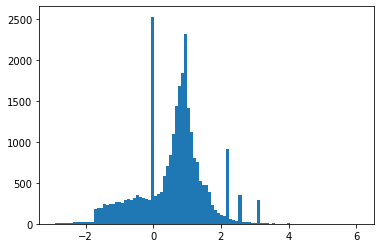

In [11]:
for features, label in packed_ds.batch(1000).take(1):
  print(features[0])
  plt.hist(features.numpy().flatten(), bins=101)

Although not normalized, the dara records are sufficient as they are for this notebook

In [0]:
N_VALIDATION = 1000
N_TRAIN = 10000
BUFFER_SIZE = 1000
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN // BATCH_SIZE

In [13]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()
train_ds

<CacheDataset shapes: ((28,), ()), types: (tf.float32, tf.float32)>

In [0]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

# Demonstrate Overfitting

## Training procedure

gradually reduce learning during training with schedules

InverseTimeDeacy = hyperbolically decrease the learning rate o1/2 of base rate at 1000 epochs, 1/3 at 2000 epochs ...

In [0]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*1000,
    decay_rate=1,
    staircase=False
)

def get_optimizer():
  return tf.keras.optimizers.Adam(lr_schedule)

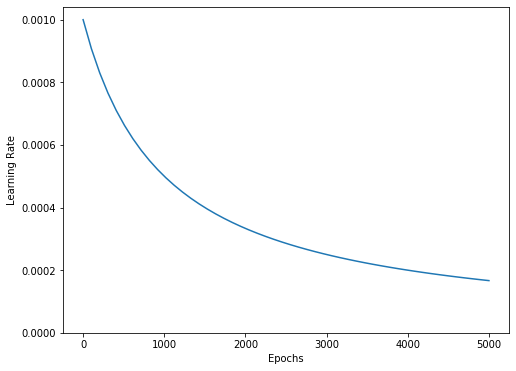

In [16]:
step = np.linspace(0, 100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step / STEPS_PER_EPOCH, lr)
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epochs')
_ = plt.ylabel('Learning Rate')

Now we include EarlyStopping to keep the procedur concise.

In [0]:
def get_callbacks(name):
  return [tfdocs.modeling.EpochDots(),
          tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy', patience=200),
          tf.keras.callbacks.TensorBoard(logdir/name)]

In [0]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
  if optimizer is None:
    optimizer = get_optimizer()
  model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics= [
                          tf.keras.losses.BinaryCrossentropy(
                              from_logits=True, name='binary_crossentropy'),
                          'accuracy'])
  model.summary()
  history = model.fit(
      train_ds,
      steps_per_epoch = STEPS_PER_EPOCH,
      epochs=max_epochs,
      validation_data=validate_ds,
      callbacks=get_callbacks(name),
      verbose=0)
  return history


### Tiny model

In [19]:
tiny_model = tf.keras.Sequential([
                                  layers.Dense(16, activation='relu', input_shape=(FEATURES,)),
                                  layers.Dense(1)
])

size_histories = {}
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                464       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4773,  binary_crossentropy:0.7769,  loss:0.7769,  val_accuracy:0.4660,  val_binary_crossentropy:0.7590,  val_loss:0.7590,  
....................................................................................................
Epoch: 100, accuracy:0.6134,  binary_crossentropy:0.6179,  loss:0.6179,  val_accuracy:0.5870,  val_binary_crossentropy:0.6269,  val_loss:0.6269,  
....................................................................................................
Epoch: 200, accuracy:0.64

(0.5, 0.7)

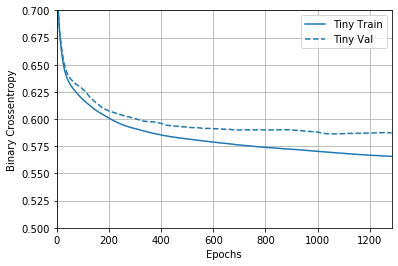

In [20]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([.5, 0.70])

Small model

In [21]:
small_model = tf.keras.Sequential([
                                   layers.Dense(16, activation='elu', input_shape=(FEATURES,)),
                                   layers.Dense(16, activation='elu'),
                                   layers.Dense(1)
])

size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16)                464       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4752,  binary_crossentropy:0.7307,  loss:0.7307,  val_accuracy:0.4490,  val_binary_crossentropy:0.7141,  val_loss:0.7141,  
....................................................................................................
Epoch: 100, accuracy:0.6263,  binary_crossentropy:0.6123,  loss:0.6123,  val_accuracy:0.6080,  val_binary_crossentropy:0.6128,  val_loss:0.

Medium model

In [22]:
medium_model = tf.keras.Sequential([
                                    layers.Dense(64, activation='elu', input_shape=(FEATURES,)),
                                    layers.Dense(64, activation='elu'),
                                    layers.Dense(64, activation='elu'),
                                    layers.Dense(1)
])

size_histories['Medium'] = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 64)                1856      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4912,  binary_crossentropy:0.6910,  loss:0.6910,  val_accuracy:0.4750,  val_binary_crossentropy:0.6775,  val_loss:0.6775,  
....................................................................................................
E

Large model

In [23]:
large_model = tf.keras.Sequential([
                                    layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
                                    layers.Dense(512, activation='elu'),
                                    layers.Dense(512, activation='elu'),
                                    layers.Dense(512, activation='elu'),
                                    layers.Dense(1)
])

size_histories['large'] = compile_and_fit(large_model, "sizes/large")

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 512)               14848     
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5156,  binary_crossentropy:0.7288,  loss:0.7288,  val_accuracy:0.5010,  val_binary_crossentr

Plot training and validation losses

lower is better

Text(0.5, 0, 'Epochs [Log Scale]')

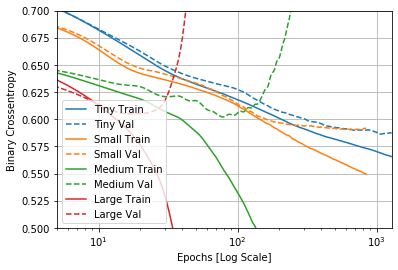

In [24]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

The tiny model is not prone to overfitting recognizable from the validation line still kind of keep the same direction as the training line

View in TensorBoard

In [25]:
%tensorboard --logdir {logdir}/sizes

display.IFrame(
    src="https://tensorboard.dev/experiment/vW7jmmF9TmKmy3rbheMQpw/#scalars&_smoothingWeight=0.97",
    width="100%", height="800px"
)

UsageError: Line magic function `%tensorboard` not found.


# Strategies to prevent overfitting

In [0]:
shutil.rmtree(logdir/'regularizers/Tiny', ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny', logdir/'regularizers/Tiny')

In [0]:
regularizer_histories = {}
regularizer_histories['Tiny'] = size_histories['Tiny']

## Add L2 regularization (Weight decay)

penalizes larger, growing weights

In [29]:
l2_model = tf.keras.Sequential([
                                layers.Dense(512, activation='elu',
                                             kernel_regularizer=regularizers.l2(0.001), 
                                             input_shape=(FEATURES,)),
                                layers.Dense(512, activation='elu',
                                             kernel_regularizer=regularizers.l2(0.001)),
                                layers.Dense(512, activation='elu',
                                             kernel_regularizer=regularizers.l2(0.001)),
                                layers.Dense(512, activation='elu',
                                             kernel_regularizer=regularizers.l2(0.001)),
                                layers.Dense(1)
])

regularizer_histories['l2'] = compile_and_fit(l2_model, 'regularizers/l2')

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 512)               14848     
_________________________________________________________________
dense_15 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_17 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 513       
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5111,  binary_crossentropy:0.8289,  loss:2.3542,  val_accuracy:0.4860,  val_binary_crossentr

The variable for which 0.001 is used for is also often referred as  `beta2`




(0.5, 0.7)

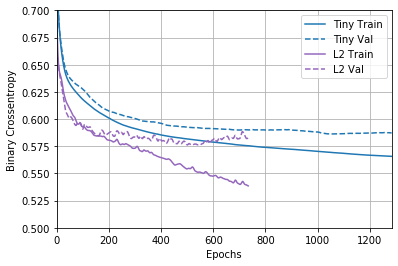

In [30]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

The L2 line competes more with the tiny model. The L2 model is based on the large model but is more resistent to overfitting!

In [0]:
result = l2_model(features)
regularization_loss = tf.add_n(l2_model.losses)

## Dropout

For each hidden layer and for each iteration: Randomly (based on given probability) drops out neurons (turn them to 0 for the time being). Decreases reliabiliy between neurons.

No dropout at test time. Scaling down by a factor equal the dropout rate instead.

In [32]:
dropout_model = tf.keras.Sequential([
                                     layers.Dense(512, activation='elu', input_shape=(FEATURES,)),
                                     layers.Dropout(0.5),
                                     layers.Dense(512, activation='elu'),
                                     layers.Dropout(0.5),
                                     layers.Dense(512, activation='elu'),
                                     layers.Dropout(0.5),
                                     layers.Dense(512, activation='elu'),
                                     layers.Dropout(0.5),
                                     layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 512)              

AttributeError: ignored

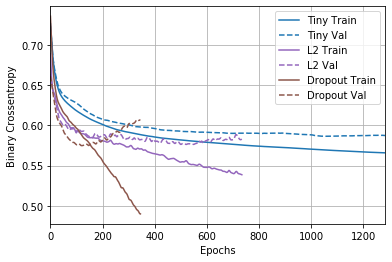

In [33]:
plotter.plot(regularizer_histories)
plt.lim([0.5, 0.7])

Similar to the L2 model, the dropout model line indicates improvements compared to the large model without any regularization.

L2 + Dropout

In [34]:
combined_model = tf.keras.Sequential([
                                     layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), 
                                                  activation='elu', input_shape=(FEATURES,)),
                                      layers.Dropout(0.5),
                                      layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), 
                                                  activation='elu', input_shape=(FEATURES,)),
                                      layers.Dropout(0.5),
                                      layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), 
                                                  activation='elu', input_shape=(FEATURES,)),
                                      layers.Dropout(0.5),
                                      layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), 
                                                  activation='elu', input_shape=(FEATURES,)),
                                      layers.Dropout(0.5),
                                      layers.Dense(1)
])

regularizer_histories['combined'] = compile_and_fit(combined_model, "regularizers/combined")

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 512)               14848     
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_28 (Dense)             (None, 512)              

(0.5, 0.7)

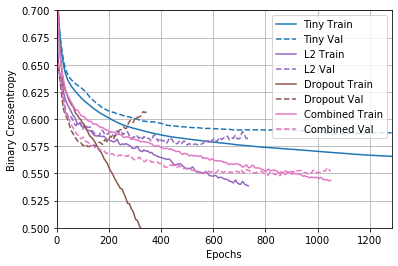

In [35]:
plotter.plot(regularizer_histories)
plt.ylim([0.5, 0.7])

The combined shows the best results

View in TensorBoard

In [36]:
%tensorboard --logdir {logdir}/regularizers

display.IFrame(
    src="https://tensorboard.dev/experiment/fGInKDo8TXes1z7HQku9mw/#scalars&_smoothingWeight=0.97",
    width = "100%",
    height="800px")

SyntaxError: ignored

Conclusion: Most commont ways to deal with/prevent overfitting:


*   Get more training data
*   Reduce capacity of the network
* add weight regularization
* add dropout

also:
* data-augmentation
* batch normalization

and combining several methods



# Save and load models

during and after training

save and share:
* code 
* trained weights, or parameters

In [0]:
!pip install -q pyyaml h5py 


## Example dataset: MNIST

In [0]:
import os
from tensorflow import keras

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

train_labels = train_labels[:1000]
test_labels = test_labels[:1000]

train_images = train_images[:1000].reshape(-1, 28*28) / 255.
test_images = test_images[:1000].reshape(-1, 28*28) / 255.

## Create model

In [49]:
def create_model():
  model = tf.keras.models.Sequential([
                                      keras.layers.Dense(512, activation='relu', input_shape=(784,)),
                                      keras.layers.Dropout(0.2),
                                      keras.layers.Dense(10)
  ])

  model.compile(optimizer='adam',
                loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  
  return model

model = create_model()
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 512)               401920    
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


## Save checkpoints during training

In [51]:
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

model.fit(train_images, train_labels, epochs=10,
          validation_data=(test_images, test_labels), callbacks=[cp_callback])

Train on 1000 samples, validate on 1000 samples
Epoch 1/10
 928/1000 [==========================>...] - ETA: 0s - loss: 1.2199 - accuracy: 0.6390
Epoch 00001: saving model to training_1/cp.ckpt
1000/1000 [==============================] - 1s 663us/sample - loss: 1.1699 - accuracy: 0.6550 - val_loss: 0.7092 - val_accuracy: 0.7800
Epoch 2/10
 928/1000 [==========================>...] - ETA: 0s - loss: 0.4393 - accuracy: 0.8750
Epoch 00002: saving model to training_1/cp.ckpt
1000/1000 [==============================] - 0s 319us/sample - loss: 0.4353 - accuracy: 0.8750 - val_loss: 0.5121 - val_accuracy: 0.8390
Epoch 3/10
 864/1000 [========================>.....] - ETA: 0s - loss: 0.3088 - accuracy: 0.9132
Epoch 00003: saving model to training_1/cp.ckpt
1000/1000 [==============================] - 0s 309us/sample - loss: 0.3103 - accuracy: 0.9140 - val_loss: 0.4738 - val_accuracy: 0.8580
Epoch 4/10
 896/1000 [=========================>....] - ETA: 0s - loss: 0.2026 - accuracy: 0.9531
Epoch

In [52]:
ls {checkpoint_dir}

checkpoint  cp.ckpt.data-00000-of-00001  cp.ckpt.index


New, fresh, untrained model

In [53]:
model = create_model()

loss, acc = model.evaluate(test_images, test_labels, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100*acc))

1000/1000 - 0s - loss: 2.4223 - accuracy: 0.0740
Untrained model, accuracy:  7.40%


Load weight from checkpoint and evaluate agina

In [54]:
model.load_weights(checkpoint_path)

loss, acc = model.evaluate(test_images, test_labels, verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100*acc))

1000/1000 - 0s - loss: 0.3934 - accuracy: 0.8740
Untrained model, accuracy: 87.40%


the model's accuracy jumped rom 7.4% to over 87% with the weights of the previous model

Callback options

In [63]:
checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weight_only=True,
    period=5)

model = create_model()

model.save_weights(checkpoint_path.format(epoch=0))
model.fit(train_images, train_labels, epochs=50, callbacks=[cp_callback],
          validation_data=(test_images, test_labels), verbose=0)


Epoch 00005: saving model to training_2/cp-0005.ckpt
INFO:tensorflow:Assets written to: training_2/cp-0005.ckpt/assets

Epoch 00010: saving model to training_2/cp-0010.ckpt
INFO:tensorflow:Assets written to: training_2/cp-0010.ckpt/assets

Epoch 00015: saving model to training_2/cp-0015.ckpt
INFO:tensorflow:Assets written to: training_2/cp-0015.ckpt/assets

Epoch 00020: saving model to training_2/cp-0020.ckpt
INFO:tensorflow:Assets written to: training_2/cp-0020.ckpt/assets

Epoch 00025: saving model to training_2/cp-0025.ckpt
INFO:tensorflow:Assets written to: training_2/cp-0025.ckpt/assets

Epoch 00030: saving model to training_2/cp-0030.ckpt
INFO:tensorflow:Assets written to: training_2/cp-0030.ckpt/assets

Epoch 00035: saving model to training_2/cp-0035.ckpt
INFO:tensorflow:Assets written to: training_2/cp-0035.ckpt/assets

Epoch 00040: saving model to training_2/cp-0040.ckpt
INFO:tensorflow:Assets written to: training_2/cp-0040.ckpt/assets

Epoch 00045: saving model to training_2

In [64]:
ls {checkpoint_dir}

checkpoint                        cp-0008.ckpt.index  cp-0030.ckpt/
cp-0000.ckpt.data-00000-of-00001  cp-0010.ckpt/       cp-0035.ckpt/
cp-0000.ckpt.index                cp-0015.ckpt/       cp-0040.ckpt/
cp-0005.ckpt/                     cp-0020.ckpt/       cp-0045.ckpt/
cp-0008.ckpt.data-00000-of-00001  cp-0025.ckpt/       cp-0050.ckpt/


In [67]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'training_2/cp-0000.ckpt'

reset model and load latest checkpoint

In [66]:
model = create_model()
model.load_weights(latest)

loss, acc = model.evaluate(test_images, test_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

1000/1000 - 0s - loss: 2.3317 - accuracy: 0.1040
Restored model, accuracy: 10.40%


Save weights manually

In [68]:
model.save_weights('./checkpoints/my_checkpoint')
model = create_model()
model.load_weights('./checkpoints/my_checkpoint')

loss, acc = model.evaluate(test_images, test_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

1000/1000 - 0s - loss: 2.3317 - accuracy: 0.1040
Restored model, accuracy: 10.40%


##Save the entire model

## SavedModel format

In [70]:
model = create_model()
model.fit(train_images, train_labels, epochs=5)

!mkdir -p saved_model
model.save('saved_model/my_model')

Train on 1000 samples
Epoch 1/5
1000/1000 [==============================] - 0s 463us/sample - loss: 1.1590 - accuracy: 0.6770
Epoch 2/5
1000/1000 [==============================] - 0s 195us/sample - loss: 0.4310 - accuracy: 0.8850
Epoch 3/5
1000/1000 [==============================] - 0s 199us/sample - loss: 0.2783 - accuracy: 0.9360
Epoch 4/5
1000/1000 [==============================] - 0s 192us/sample - loss: 0.2046 - accuracy: 0.9530
Epoch 5/5
1000/1000 [==============================] - 0s 191us/sample - loss: 0.1547 - accuracy: 0.9660
INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [72]:
!ls saved_model

!ls saved_model/my_model

my_model
assets	saved_model.pb	variables


In [73]:
new_model = keras.models.load_model('saved_model/my_model')
new_model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_48 (Dense)             (None, 512)               401920    
_________________________________________________________________
dropout_18 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_49 (Dense)             (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


Restored model is compiled with same arguments as original one.

In [77]:
loss, acc = new_model.evaluate(test_images, test_labels, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

print(new_model.predict(test_images).shape)

1000/1000 - 0s - loss: 0.4145 - accuracy: 0.8650
Restored model, accuracy: 86.50%
(1000, 10)


## HDF5 format

In [78]:
model = create_model()
model.fit(train_images, train_labels, epochs=5)

model.save('my_model.h5')

Train on 1000 samples
Epoch 1/5
1000/1000 [==============================] - 0s 472us/sample - loss: 1.1934 - accuracy: 0.6410
Epoch 2/5
1000/1000 [==============================] - 0s 208us/sample - loss: 0.4497 - accuracy: 0.8760
Epoch 3/5
1000/1000 [==============================] - 0s 205us/sample - loss: 0.2872 - accuracy: 0.9260
Epoch 4/5
1000/1000 [==============================] - 0s 209us/sample - loss: 0.2151 - accuracy: 0.9450
Epoch 5/5
1000/1000 [==============================] - 0s 201us/sample - loss: 0.1602 - accuracy: 0.9670


In [80]:
new_model = keras.models.load_model('my_model.h5')
new_model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_50 (Dense)             (None, 512)               401920    
_________________________________________________________________
dropout_19 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 10)                5130      
Total params: 407,050
Trainable params: 407,050
Non-trainable params: 0
_________________________________________________________________


In [81]:
loss, acc = new_model.evaluate(test_images, test_labels, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100*acc))

1000/1000 - 0s - loss: 0.4313 - accuracy: 0.8590
Restored model, accuracy: 85.90%


Everything's saved:


*   weights
*   architecture
* training configuration
* optimizer and state (if any)

